In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [4]:
from collections import defaultdict

In [5]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from zoo.fpn import DPFPNet, FPNSumBottleneck, FPNDecoderBlock
from utils.attributes_dataset import ISIC_Dataset, EqualizedSampler, ValSampler, MEAN, STD, attributes

from utils.losses import BCEDiceJaccardLoss
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner

from utils.attributes_augmentations import Augmentation
%load_ext autoreload
%autoreload 2

In [6]:
# GPU_IDX = 1
EPS = 1e-5
LR_GAMMA = .95
SEED = 42
EPOCHS_NB = 50
IOUS = ['iou_attributes', 'iou_segment']
PATHS = {
    'DATA': '../data/cropped/',
}

In [7]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[(dataset.keys[idx], 0)]
    pred_mask = F.sigmoid(model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    channel = np.unique(np.where(true_mask)[-1]).min()
    pred_mask = pred_mask.T[..., channel]
    true_mask = true_mask[..., channel]
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask)
        ax[2].imshow(pred_mask)
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [8]:
torch.cuda.set_device(0)

In [9]:
def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True

def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None


def freeze(model, end_block=-1):
    dpn = list(model.children())
    for l, child in enumerate(dpn[0].encoder_stages.children()):
        for param in child.parameters():
            param.requires_grad = l > end_block

    return model

In [10]:
from torch.utils.data.sampler import Sampler

class TupleBatchSampler(object):
    r"""Wraps another sampler to yield a mini-batch of indices.

    Args:
        sampler (Sampler): Base sampler.
        batch_size (int): Size of mini-batch.
        drop_last (bool): If ``True``, the sampler will drop the last batch if
            its size would be less than ``batch_size``

    Example:
        >>> list(BatchSampler(range(10), batch_size=3, drop_last=False))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]
        >>> list(BatchSampler(range(10), batch_size=3, drop_last=True))
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    """

    def __init__(self, sampler, batch_size, drop_last):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if not isinstance(batch_size, int) or isinstance(batch_size, bool) or \
                batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        if not isinstance(drop_last, bool):
            raise ValueError("drop_last should be a boolean value, but got "
                             "drop_last={}".format(drop_last))
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for idx in self.sampler:
#             batch.append(int(idx))
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size


In [12]:
def get_datasets(data_dir, fold, aug_strength=1.):
    amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
    train_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                                 augmentator=Augmentation, aug_params={'side': 512, 'strength': aug_strength}, part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, seed=SEED, amounts=amounts,
                               augmentator=Augmentation, aug_params={'side': 576}, is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, train_batch_size=28):
    areas = pickle.load(open('../data/attribute_areas.pkl', 'rb'))
    train_datagen = torch.utils.data.DataLoader(train_dataset, 
                                                batch_sampler=TupleBatchSampler(
                                                    EqualizedSampler(train_dataset, areas), 
                                                    train_batch_size, 
                                                    drop_last=True
                                                ),
                                                num_workers=8)
    val_datagen = torch.utils.data.DataLoader(val_dataset,
                                              batch_sampler=TupleBatchSampler(
                                                  ValSampler(val_dataset, areas), 
                                                  batch_size=1,
                                                  drop_last=False
                                              ),
                                              num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
    model = DPFPNet(6, 3, encoder_name='dpn68', model_type='fpn', dropout=0.3)
    model.cuda();

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.state_dict())

    return model

In [13]:
def make_step(model, data, loss, opt=None, training=True):
    images = Variable(data['images']).cuda()
    masks = Variable(data['masks'] > 120).cuda().float()

    predictions = model(images)
    l = loss(predictions, masks)
    pred = F.sigmoid(predictions).data.cpu().numpy()
    intersection, union = calc_iou(pred > 0.5, masks.data.cpu().numpy())

    if training:
        l.backward()
        opt.step()

    return {
        'loss': l, 
        'intersection': intersection,
        'union': union,
    }

In [14]:
def train_on_epoch(model, loss, opt, datagen, epsilon=1e-5, hard_negative_miner=None):
    model.train()
    meters = list()

    for data in tqdm(datagen):
        opt.zero_grad()
        meters.append(make_step(model, data, loss, opt, training=True))

        if hard_negative_miner is not None:
            hard_negative_miner.update_cache(meters[-1], data)
            if hard_negative_miner.need_iter():
                make_step(model, hard_negative_miner.get_cache(), loss, opt, training=True)
                hard_negative_miner.invalidate_cache()

    losses = sum([meter['loss'] for meter in meters])
    losses = losses.data.cpu().numpy() / len(meters)
    ious = sum([meter['intersection'] for meter in meters]) / sum([meter['union'] for meter in meters])

    opt.zero_grad()

    return losses, ious

In [15]:
def validate(model, loss, datagen):
    model.eval()
    ious, losses = list(), list()

    with torch.no_grad():
        for data in tqdm(datagen):
            meter = make_step(model, data, loss, training=False)
            ious.append({key: meter[key] for key in ['intersection', 'union']})
            losses.append(meter['loss'].data.cpu().numpy())

    return losses, ious

In [16]:
def visualize(train_losses, val_losses, train_iou, val_iou):
    clear_output(wait=True)
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    axes[0].plot(train_losses, label='Train')
    for i, key in enumerate(['segm']):
            axes[0].plot([v[key] for v in train_iou], label='Train {}'.format(key), alpha=0.7, color='C{}'.format(i * 2))    
            axes[0].plot([v[key] for v in val_iou], label='Val {}'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

    axes[0].plot(val_losses, label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    key = 'full_attr'
    nb_classes = len(val_iou[0][key])

    for i in range(nb_classes):
        axes[1].plot([v[key][i] for v in train_iou], label='Train {}'.format(attributes[i].split('_')[-2]), alpha=0.7)
    
    for i in range(nb_classes):
        axes[1].plot([v[key][i] for v in val_iou], label='Val {}'.format(attributes[i].split('_')[-2]), alpha=0.7)

    axes[1].set_title('IoU')
    axes[1].legend()
    axes[1].grid()

    plt.show()

In [17]:
def visualize_iou(val_iou):
    clear_output(wait=True)
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    for i, key in enumerate(['attr', 'segm',]):
        axes[0].plot([v[key] for v in val_iou], label='{}'.format(key), alpha=0.7, color='C{}'.format(i))
    axes[0].set_title('General IoU')
    axes[0].legend()
    axes[0].grid()

    key = 'full_attr'
    nb_classes = len(val_iou[0][key])
    for i in range(nb_classes):
        axes[1].plot([v[key][i] for v in val_iou], label='{}'.format(attributes[i]), alpha=0.7, color='C{}'.format(i))
    axes[1].set_title('Per Class IoU')
    axes[1].legend()
    axes[1].grid()

    plt.show()

In [18]:
def dump_intermediates(model, val_dataset, fold, epoch_i):
    model.eval()
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 0, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=32, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 32, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=True, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 17, epoch_i)
    )

In [19]:
def orchestrate(data_dir, fold, model=None, losses=None, model_pth=None, 
                epoch_nb=1, map_location=None, nums=[3, 2, 1, -1], 
                lr=1e-4, aug_strength=1., hard_negative_miner=None,
                checkpoints_pth='checkpoints', verbose=False, devices=None, 
                train_batch_size=8, lr_scheduler=None, strength_decay=1., min_strength=.7, converge_appearence=.1):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
    if model is None:
        model = get_model(model_pth, map_location, devices)
    if model_pth is not None:
        losses = pickle.load(open(path.format(fold, 'loss'), 'rb'))
    if losses is None:
        losses = defaultdict(list)
    last_epoch = len(losses)

    loss = BCEDiceJaccardLoss(
        weights={
            'bce': .5,
            'jacc': .25,
            'dice': .25,
        },
        chnls_w=np.array([1.] * 5 + [.1])
    )
    opt = optim.Adam(model.parameters(), lr=lr)
    for group in opt.param_groups:
        group.setdefault('initial_lr', group['lr'])

    if lr_scheduler is not None:
        lr_scheduler = lr_scheduler(opt, LR_GAMMA, last_epoch)

    train_losses, val_losses = [], []
    train_iou, val_iou = [], []
    
    train_dataset, val_dataset = get_datasets(data_dir, fold, aug_strength * strength_decay ** last_epoch)
    train_datagen, val_datagen = get_datagens(train_dataset, val_dataset, train_batch_size=train_batch_size)

    try:
        for epoch_i in range(last_epoch, epoch_nb):
            if nums is not None:
                idx = min(3, epoch_i // 10)
                model = freeze(model, nums[idx])
                unfreeze_bn(model)
            else:
                model = freeze(model, -1)

            if lr_scheduler is not None:
                lr_scheduler.step()

            l, iou = train_on_epoch(model, loss, opt, train_datagen, hard_negative_miner=hard_negative_miner)
            iou = {
                'attr': iou[:-1].mean(),
                'segm': iou[-1],
                'full_attr': iou[:-1],
            }
            losses['train_losses'].append(l)
            losses['train_iou'].append(iou)

            l, ious = validate(model, loss, val_datagen)
            ious = sum([meter['intersection'] for meter in ious]) / sum([meter['union'] for meter in ious])
            ious = {
                'attr': ious[:-1].mean(),
                'segm': ious[-1],
                'full_attr': ious[:-1],
            }
            losses['val_losses'].append(np.mean(l))
            losses['val_iou'].append(ious)

            if verbose:
                visualize(
                    losses['train_losses'], 
                    losses['val_losses'], 
                    losses['train_iou'], 
                    losses['val_iou']
                )
                dump_intermediates(model, val_dataset, fold, epoch_i)

            if train_dataset.aug_params['strength'] > min_strength:
                train_dataset.aug_strength_decay(strength_decay)

            if (checkpoints_pth is not None) and ((epoch_i + 1) % 10 == 0):
                torch.save(model, path.format(fold, epoch_i))
                pickle.dump(losses, open(path.format(fold, 'loss'), 'wb'))
                print(path)

            train_dataset.converge_appearence(decay=converge_appearence)

    except KeyboardInterrupt:
        return model, losses

    return model, losses

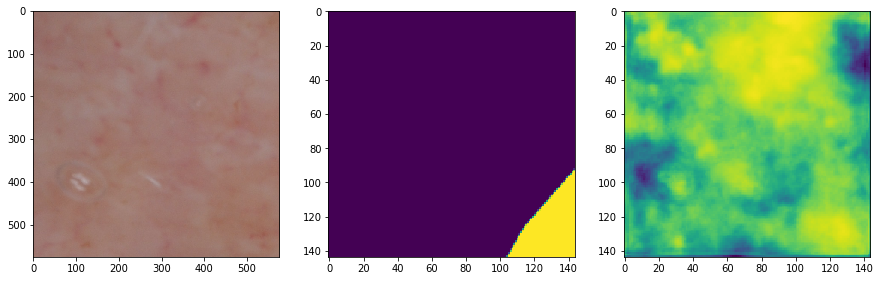

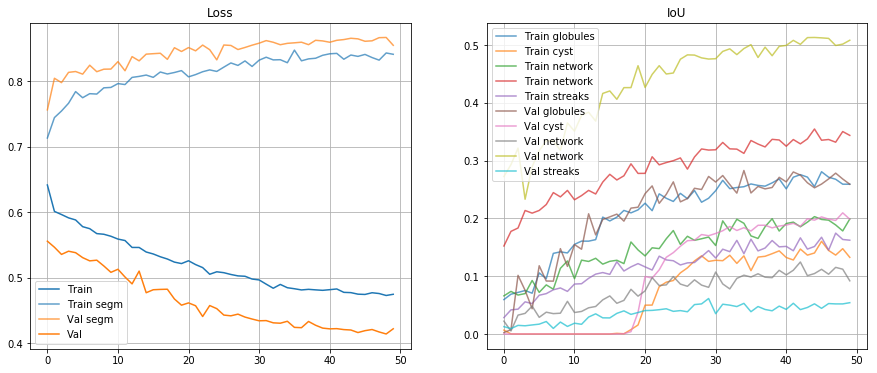

attributes_checkpoints/fpn_dpn68/fold_{}_checkpoint.epoch_{}


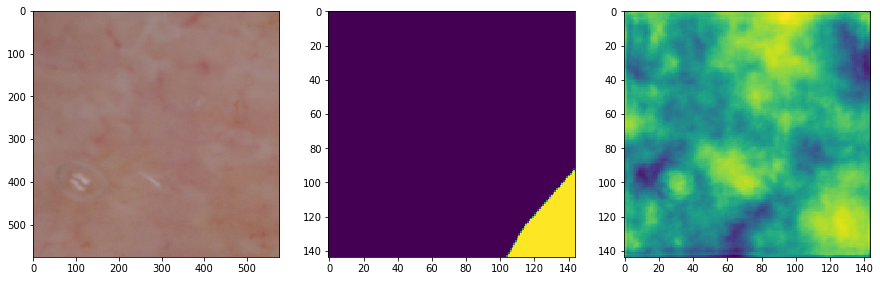

In [20]:
fold = 0
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn68/', 
    lr=7e-5,
    aug_strength=1.3,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=0.75,
    verbose=True,
    train_batch_size=16,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

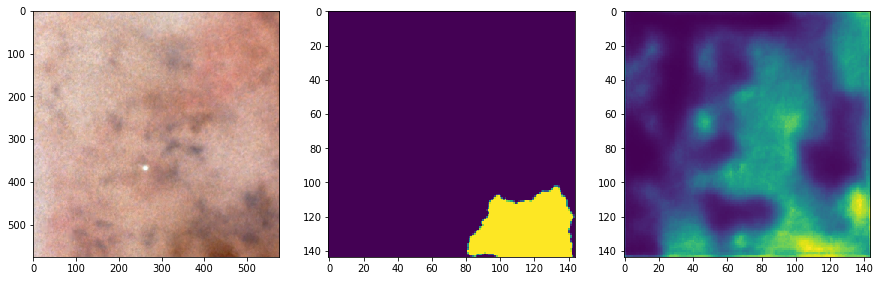

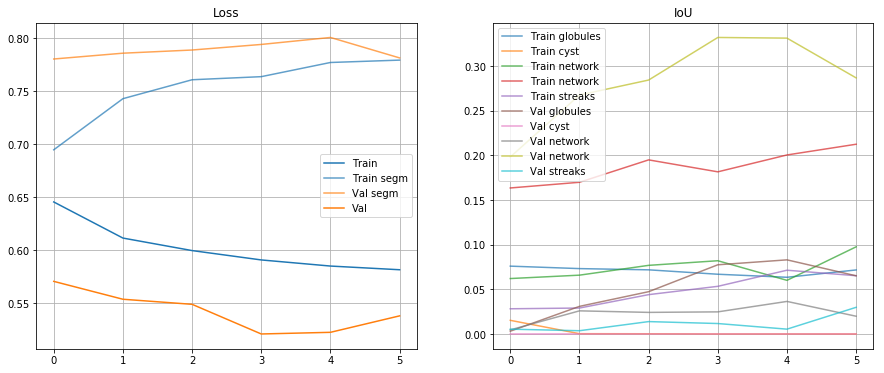

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/120 [00:00<?, ?it/s]

appearence recomputed
[0.19607843 0.19607843 0.19607843 0.19607843 0.19607843 0.01960784]


 59%|█████▉    | 71/120 [01:13<00:50,  1.03s/it]Process Process-455:
Process Process-456:
Traceback (most recent call last):
Process Process-453:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-449:
Process Process-451:
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File 

In [ ]:
fold = 1
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn68/', 
    lr=7e-5,
    aug_strength=1.3,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=0.75,
    verbose=True,
    train_batch_size=16,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
fold = 2
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn68/', 
    lr=7e-5,
    aug_strength=1.3,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=0.75,
    verbose=True,
    train_batch_size=16,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
fold = 3
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn68/', 
    lr=7e-5,
    aug_strength=1.3,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=0.75,
    verbose=True,
    train_batch_size=16,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

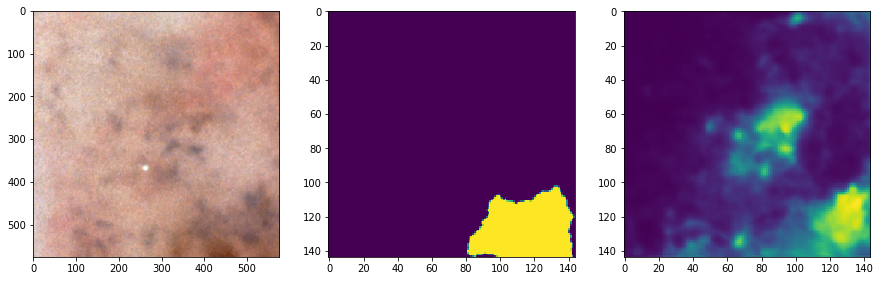

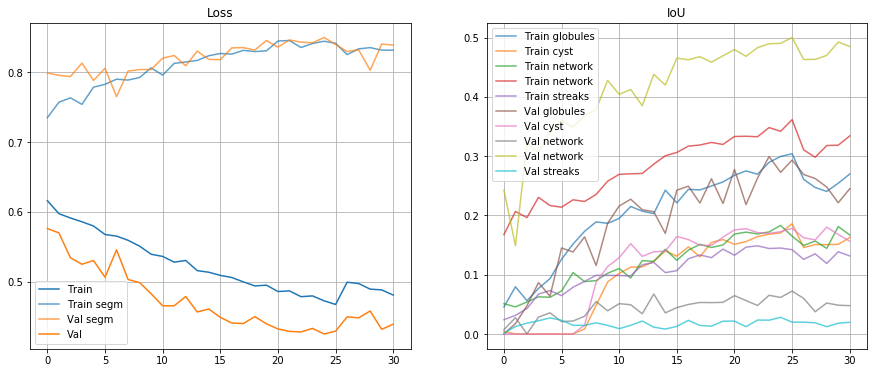

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/322 [00:00<?, ?it/s]

appearence recomputed
[0.19607843 0.19607843 0.19607843 0.19607843 0.19607843 0.01960784]


 90%|█████████ | 291/322 [05:01<00:32,  1.04s/it]

In [ ]:
fold = 1
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    model_pth='attributes_checkpoints/fpn_dpn92/fold_1_checkpoint.epoch_19',
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn92/', 
    lr=5e-5,
    aug_strength=1.3,
    converge_appearence=.0,
    strength_decay=.97, 
    min_strength=0.75,
    verbose=True,
    train_batch_size=6,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

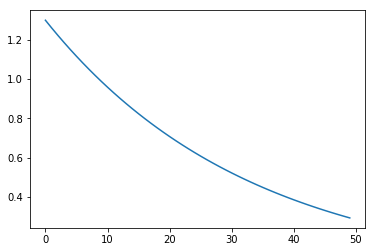

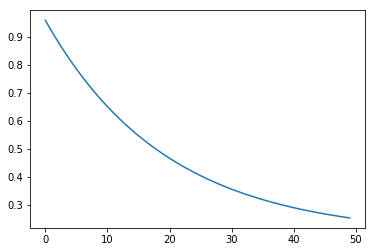

In [26]:
plt.plot([1.3 * .97 ** i for i in range(50)])
plt.show()
ass = []
a = 1.
l = .05
for i in range(50):
    a = a * (1 - l) + l * .19
    ass.append(a)
plt.plot(ass)

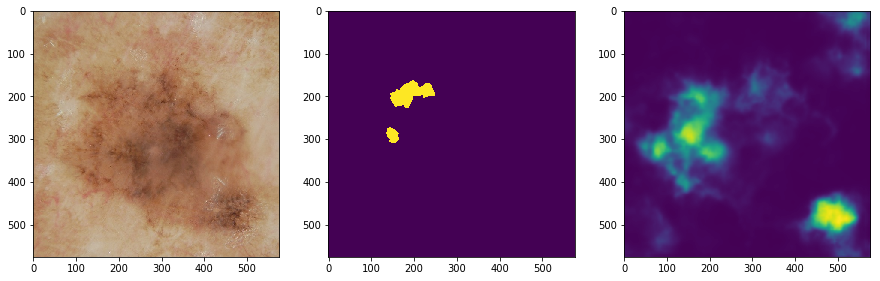

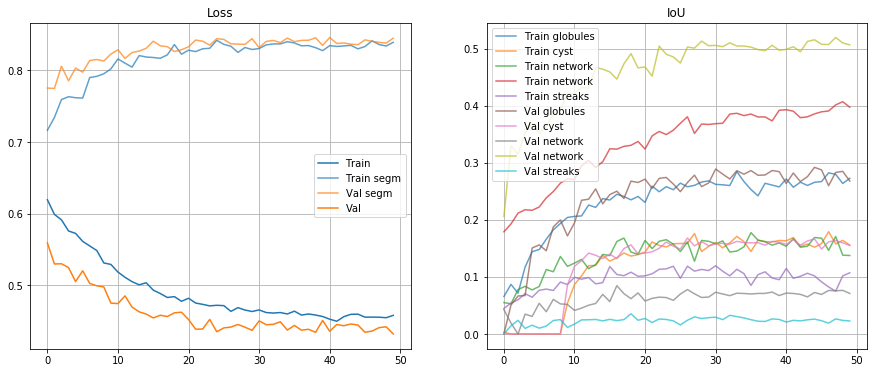

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributes_checkpoints/dpn92/fold_{}_checkpoint.epoch_{}


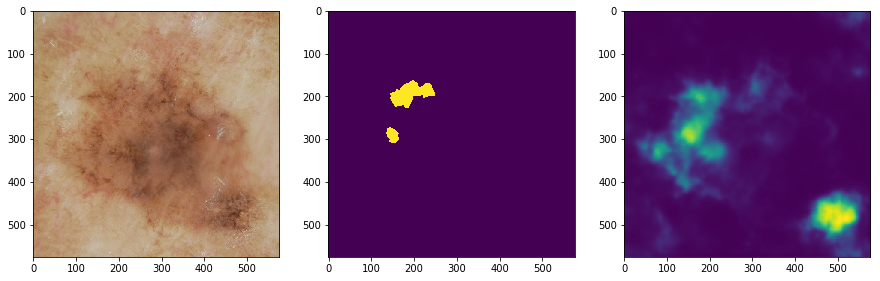

In [19]:
fold = 2
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn92/', 
    lr=5e-5,
    aug_strength=1.3,
    converge_appearence=.03,
    strength_decay=.97, 
    min_strength=0.7,
    verbose=True,
    train_batch_size=6,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=7),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

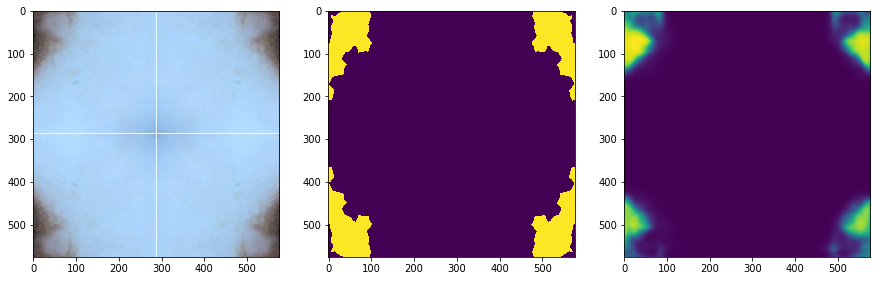

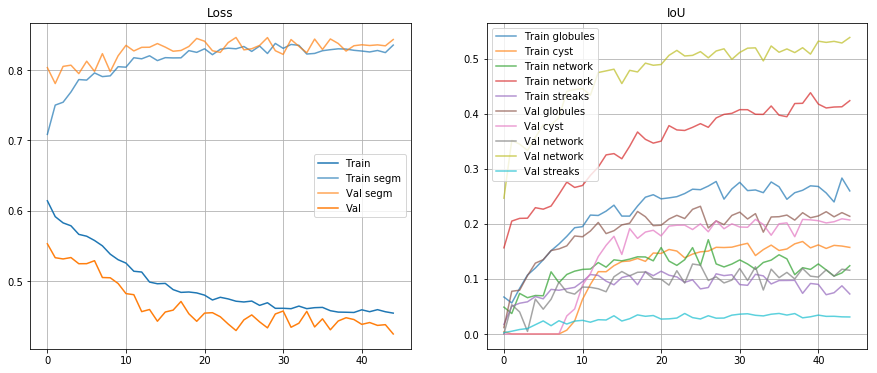

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/323 [00:00<?, ?it/s]

appearence recomputed
[0.17533341 0.19090667 0.09391875 0.35669292 0.07617706 0.10697118]


 78%|███████▊  | 252/323 [04:28<01:15,  1.07s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
fold = 3
model, losses = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='attributes_checkpoints/fpn_dpn92/', 
    lr=5e-5,
    aug_strength=1.3,
    converge_appearence=.05,
    strength_decay=.97, 
    min_strength=0.7,
    verbose=True,
    train_batch_size=6,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=7),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
import scipy.ndimage

train_dataset, val_dataset = get_datasets('../data/shrinked/', 2, 1)
train_datagen, val_datagen = get_datagens(train_dataset, val_dataset, train_batch_size=11)


i = 13


m = val_dataset[val_dataset.keys[i]]['masks'].numpy()[3: 4]
dm = scipy.ndimage.binary_dilation(m, iterations=5)
dm *= np.logical_not(m)
plt.figure(figsize=(10, 10))
plt.imshow((np.rollaxis(dm * 10 + val_dataset[val_dataset.keys[i]]['images'].numpy(), 0, 3) * STD + MEAN)[..., ::-1])
plt.show()
plt.imshow(val_dataset[val_dataset.keys[i]]['masks'].numpy().sum(0))
print(np.where(val_dataset[val_dataset.keys[i]]['masks'].numpy().sum((1, 2))))

In [36]:
fold = 2

model = torch.load(
    os.path.join('dpn_checkpoints', 'fold_{}_checkpoint.epoch_{}'.format(fold, 10 * (EPOCHS_NB // 10) - 1)), 
)

train_dataset, val_dataset = get_datasets(PATHS['DATA'], fold, '_shrinked')
_, val_datagen = get_datagens(train_dataset, val_dataset)
loss = LossBinary(jaccard_weight=.3)
l, iou, losses, ious = validate(model, loss, val_datagen)

100%|██████████| 648/648 [00:42<00:00, 15.39it/s]


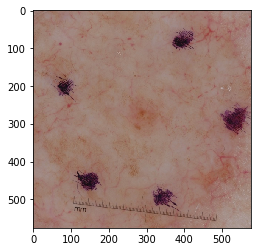

In [115]:
plt.imshow((np.rollaxis(val_dataset[n][0].data.cpu().numpy(), 0, 3) * std + mean)[..., ::-1])

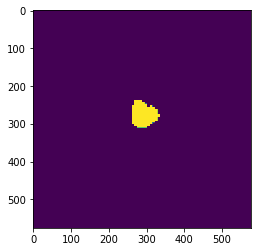

In [116]:
plt.imshow(np.squeeze(val_dataset[n][1].data.cpu().numpy()))

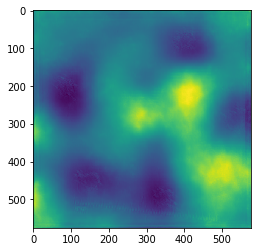

In [117]:
plt.imshow(np.squeeze(labels.data.cpu()))

In [23]:
model_ = models[0]
sd_ = model_.state_dict()

for model in tqdm(models[1:]):
    sd = model.state_dict()
    for key in sd.keys():
        sd_[key] += sd[key]

for key in sd.keys():
    sd_[key] /= 5.

100%|██████████| 4/4 [00:00<00:00, 124.23it/s]


In [25]:
l, iou = validate(model, loss, val_datagen)

  0%|          | 0/648 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 648/648 [00:41<00:00, 15.55it/s]
